In [2]:
from pathlib import Path
import glob 
from pymatgen.io.cif import CifParser
from pymatgen.io.feff.sets import FEFFDictSet

from larch import Interpreter
from larch.xafs.feffrunner import feffrunner

# cif ---> multiple path files according to physics equation

In [3]:
import os
import subprocess
from pymatgen.io.cif import CifParser
from pymatgen.io.feff.sets import FEFFDictSet

def make_and_run_feff(cif_file, out_dir,
                      absorber="Ni", radius=5.0, edge="K",
                      feff_exe="feff8l"):
    os.makedirs(out_dir, exist_ok=True)

    # 1) Parse CIF → structure
    struct = CifParser(cif_file).get_structures()[0]

    # 2) Generate basic feff.inp with ff2chi=1
    feff_set = FEFFDictSet(
        absorbing_atom   = absorber,
        structure        = struct,
        radius           = radius,
        edge             = edge,
        config_dict      = {},
        user_tag_settings={"CONTROL": {"ff2chi": 1}}
    )
    feff_set.write_input(out_dir)

    # 3) Read, patch, write back
    inp_path = os.path.join(out_dir, "feff.inp")
    new_lines = []
    saw_control = saw_print = False

    for line in open(inp_path):
        # After writing or seeing a CONTROL line, inject our CONTROL+PRINT
        if line.strip().startswith("CONTROL") and not saw_control:
            new_lines.append(
                "*         pot    xsph  fms   paths genfmt ff2chi\n"
                "CONTROL   1      1     1     1     1      1\n"
            )
            new_lines.append(
                "PRINT     1      0     0     0     0      3\n"
            )
            saw_control = saw_print = True
            # skip any original CONTROL/PRINT lines
            continue

        # If CONTROL never appeared before POTENTIALS, inject just before POTENTIALS
        if not saw_control and line.strip().startswith("POTENTIALS"):
            new_lines.append(
                "*         pot    xsph  fms   paths genfmt ff2chi\n"
                "CONTROL   1      1     1     1     1      1\n"
                "PRINT     1      0     0     0     0      3\n"
            )
            saw_control = saw_print = True

        new_lines.append(line)

    with open(inp_path, "w") as f:
        f.writelines(new_lines)

    # 4) Run the real FEFF8L (must be the Fortran binary!)
    print(f"Running {feff_exe} in {out_dir} …")
    subprocess.run([feff_exe], cwd=out_dir, check=True)
    print("Done; check for feff0001.dat … in", out_dir)

# examples
## automatically generate feff inp files from cif files in the cif_files folder

### generates the following paths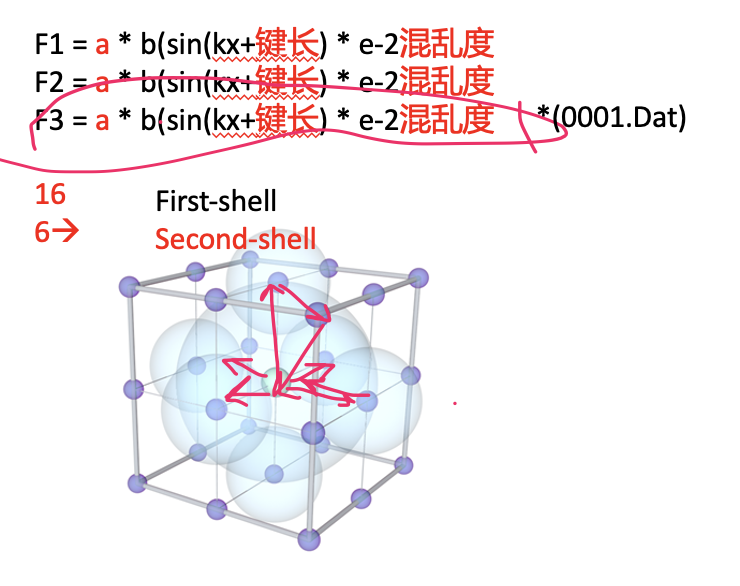

In [ ]:
cif_all = glob.glob("cif_files/*.cif")

for cif_i in cif_all:
    # This will write inputs into "test/", run FEFF, and drop feffNNNN.dat files there
    name = cif_i.split('/')[-1].split('.')[0]
    make_and_run_feff(cif_i, 
                      'FEFF_paths/'+name, # the folder where the calculated output files are going to be saved 
                    #   absorber="Ni", # absorbing atom of the spectrum
                      radius=5.0, # the range 
                      edge="K"
                      )


Running feff8l in FEFF_paths/Ni_foil …
#= Feff85l 2025-05-25 19:46:51
#= Feff85l rdinp module
 Feff8L (EXAFS)      release  0.1
 comment: None given
 Source:
 Structure Summary:  Ni1
 Reduced formula:  Ni
 space group: (Fm-3m), space number:  (225)
 abc:  2.457299   2.457299   2.457299
 angles: 60.000000  60.000000  60.000000
 sites: 1
#= Feff85l pot module
 Calculating potentials ...
    free atom potential and density for atom type    0
    free atom potential and density for atom type    1
    initial state energy
    overlapped potential and density for unique potential    0
    overlapped potential and density for unique potential    1
    muffin tin radii and interstitial parameters
    : ipot, Norman radius, Muffin tin radius, Overlap
         0  1.34532E+00  1.30752E+00  1.07234E+00
         1  1.36592E+00  1.32494E+00  1.07778E+00
    : mu_old=   -11.357
 Done with module 1: potentials.
#= Feff85l xsph module
 Calculating cross-section and phases...
    absorption cross sectio

# run a single cif file
## you need to give the specific cif file name, and tell the element of the spectrum (absorber)

In [ ]:
# This will write inputs into "test/", run FEFF, and drop feffNNNN.dat files there
name = ''
absorber = 'Y'

make_and_run_feff(f"cif_files/{name}.cif", 
                  'FEFF_paths/'+name, 
                  absorber=absorber, # the element of the spectrum
                  radius=5.0, # define a range 
                  edge="K"
                  )


Running feff8l in FEFF_paths/Y2O3_Guannan …
#= Feff85l 2025-05-13 16:22:07
#= Feff85l rdinp module
 Feff8L (EXAFS)      release  0.1
 comment: None given
 Source:
 Structure Summary:  Y16 O24
 Reduced formula:  Y2O3
 space group: (Ia-3), space number:  (206)
 abc:  9.184719   9.184719   9.184719
 angles:109.471221 109.471221 109.471221
 sites: 40
#= Feff85l pot module
 Calculating potentials ...
    free atom potential and density for atom type    0
    free atom potential and density for atom type    1
    free atom potential and density for atom type    2
    initial state energy
    overlapped potential and density for unique potential    0
    overlapped potential and density for unique potential    1
    overlapped potential and density for unique potential    2
    muffin tin radii and interstitial parameters
    : ipot, Norman radius, Muffin tin radius, Overlap
         0  1.64675E+00  1.55909E+00  1.15000E+00
         1  1.12027E+00  1.03369E+00  1.15000E+00
         2  1.74753

# Run a seperate FEFF inp file

### this is because sometimes, we modify the *.inp file rather than auto-generating FEFF.inp file from .cif file

In [9]:
feff_dir = 'FEFF_paths' # give the folder, where it contains the *.inp file

subprocess.run(["feff8l"], cwd=feff_dir, check=True)

Could not find feff.inp file in folder '/Users/juanjuanhuang/Desktop/Python/Dr.XAFS/materials/Larch_calc_example/FEFF_paths'

CompletedProcess(args=['feff8l'], returncode=0)